# 들어가며
기계 학습의 대표적인 방법들은 *지도학습*, *비지도 학습*, 그리고 *강화 학습* 이다. 이번 포스트에서는 이 중 *비지도 학습* 방법 중 하나인 K-means를 활용한 군집화(clustering)기법에 대한 예제 코드이다.

이번 포스트의 jupyter notebook과 csv파일들은 모두 [github](https://github.com/leeh8911/BeSuperRepo/tree/main/Knowledge/Python/Clustering%20Excercise)에서 확인 할 수 있다.

# 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# 데이터 불러오기 및 확인
주어진 train, test 데이터 셋을 로드한다.

In [2]:
df_train = pd.read_csv("./input_train.csv")
df_test = pd.read_csv("./input_test.csv")

In [3]:
print(df_train.shape)
df_train.head()

(9999, 5)


,1.078734452,1.684207748,-1.697788431,1.648822418,13.00967663
0,0.054549,0.040486,0.976355,0.557014,-9.760446
1,1.192383,-1.471495,1.522287,-1.294598,-5.511185
2,-0.173229,0.716604,-0.934982,1.043867,17.703281
3,-0.619846,-0.365162,-1.487529,-0.102718,-5.883243
4,1.585655,0.728519,-0.237613,0.944235,13.855260


In [4]:
print(df_test.shape)
df_test.head()

(1999, 5)


,-1.067544264,1.959152616,-2.279075869,0.978654322,-10.55106835
0,-1.553500,-1.542898,0.979257,-0.815807,11.912946
1,0.860294,0.916555,0.613720,-0.097540,26.607359
2,-0.015839,1.279196,-1.161477,0.362325,-15.563002
3,-0.063135,-0.337933,0.987439,0.223840,-7.202818
4,0.526858,0.191385,-0.905205,-0.368720,14.430606


train, test 데이터의 각 열의 이름이 이상하다. 이는 데이터 파일인 `csv`파일 맨 윗줄에 일반적으로 각 데이터의 이름이 명시되어 이를 헤더라 부르는데, 주어진 `csv`파일에는 없다. 따라서 header가 없는 데이터 파일이라는 것을 명시하기 위해 `header` 파라미터에 `None` 값을 넣어준다.

In [5]:
df_train = pd.read_csv("./input_train.csv", header = None)
df_test = pd.read_csv("./input_test.csv", header = None)

In [6]:
print(df_train.shape)
df_train.head()

(10000, 5)


,0,1,2,3,4
0,1.078734,1.684208,-1.697788,1.648822,13.009677
1,0.054549,0.040486,0.976355,0.557014,-9.760446
2,1.192383,-1.471495,1.522287,-1.294598,-5.511185
3,-0.173229,0.716604,-0.934982,1.043867,17.703281
4,-0.619846,-0.365162,-1.487529,-0.102718,-5.883243


In [7]:
print(df_test.shape)
df_test.head()

(2000, 5)


,0,1,2,3,4
0,-1.067544,1.959153,-2.279076,0.978654,-10.551068
1,-1.553500,-1.542898,0.979257,-0.815807,11.912946
2,0.860294,0.916555,0.613720,-0.097540,26.607359
3,-0.015839,1.279196,-1.161477,0.362325,-15.563002
4,-0.063135,-0.337933,0.987439,0.223840,-7.202818


# 간단한 데이터 분석
주어진 데이터셋은 5개의 열로 이루어져 있고, 각각은 연속 수치형 데이터로 보인다. 따라서 각각의 데이터를 분석하는 것 보단, 간단히 분석하기 위해 5개를 한눈에 볼 수 있는 `seaborn`의 `PairGrid`를 사용해보자. 대각 성분은 각 열의 분포를 확인하기 위한 `kdeplot`, 상위 성분은 각각의 점들의 분포를 확인하기 위한 `scatterplot`, 하위 성분은 밀도를 구체적으로 확인하기 위한 `kdeplot`을 사용해보자.

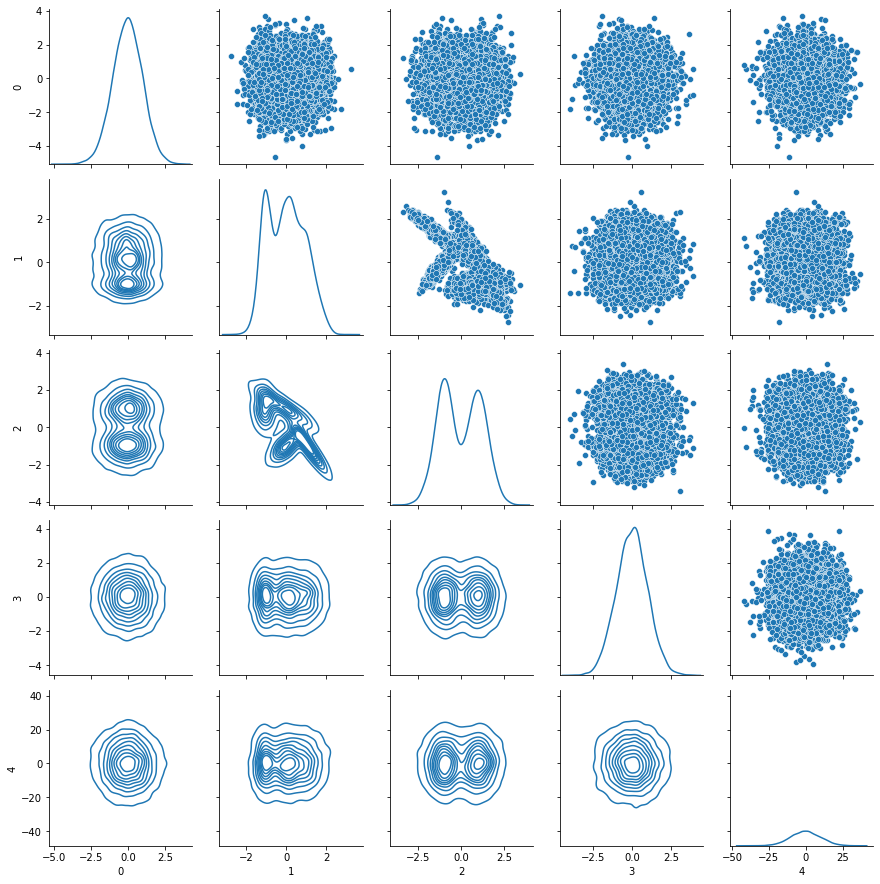

In [8]:
g = sns.PairGrid(df_train)
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot)
g.map_lower(sns.kdeplot)

`4`열의 데이터만 분포가 다른 것들과 다르다. 대부분은 10보다 작은 값에 분포하지만, `4`열의 데이터만 50에 가까운 크기를 갖는 것을 볼 수 있다. `1`, `2` 열은 데이터는 2개의 mode를 갖는다. 따라서 군집화를 할 때, 데이터를 크게 2개의 군집으로 묶을 수 있을 것이라 예상해볼 수 있다.

# 데이터 전처리
`4`열의 데이터의 분포가 다른 4개의 열들과 다르다는 것을 확인하였으니, 스케일을 균일하게 맞춰주기 위해 평균이 0, 편차가 1인 표준정규분포화 하자. `df_train`를 `df_norm`으로 복사한 다음, `sklearn`의 `StandardScaler`를 활용하여 변환을 해준다.

In [9]:
df_norm = df_train.copy()
scaler = StandardScaler()
np.array(df_norm[4]).reshape(-1, 1)
df_norm[4] = scaler.fit_transform(np.array(df_norm[4]).reshape(-1, 1)).reshape(-1)

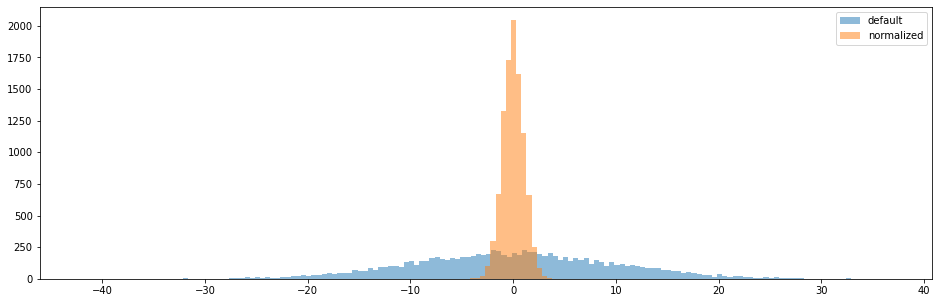

In [10]:
fig = plt.figure(figsize = (16, 5))
plt.hist(df_train[4], bins = np.arange(df_train[4].min(), df_train[4].max()+0.5, 0.5), label = 'default', alpha = 1/2)
plt.hist(df_norm[4], bins = np.arange(df_norm[4].min(), df_norm[4].max()+0.5, 0.5), label = 'normalized', alpha = 1/2)
plt.legend()

`4`열의 데이터가 표준화 이전과 이후에 큰 차이를 보임을 알 수 있다. `default`는 표준화 이전의 데이터이고 `normalized`는 표준화 된 데이터이다.

# 군집화
*3. 간단한 데이터 분석*에서 보았던 것 처럼, 데이터는 크게 2개의 군집으로 나눌 수 있다. 따라서 `sklearn`의 군집화 기법 중 하나인`KMeans`를 사용한다.

In [11]:
model = KMeans(n_clusters = 2)

군집화 결과도 하나의 데이터 프레임에 포함해주기 위해 `df_fit`을 만들고, `model`의 `fit_predict` 함수를 활용해 군집화 결과를 출력한다.

In [12]:
df_fit = df_norm.copy()
df_fit['cluster'] = model.fit_predict(df_fit)

군집화 결과의 대표값인 중심점의 결과는 다음과 같다.

In [13]:
model.cluster_centers_

array([[-7.76717045e-03, -6.96423899e-01,  1.09249921e+00,
        -5.26539542e-03, -7.18284061e-04],
       [-2.56455209e-02,  5.90663263e-01, -9.25675071e-01,
        -2.09290748e-03,  5.98460322e-04]])

데이터가 5차원의 정보이기 때문에, 시각적으로 군집화 결과를 확인하기가 어렵다. 따라서 이를 확인하기 위해 PCA를 통해 차원축소를 한다.

In [14]:
pca = PCA(n_components=2) # 주성분을 몇개로 할지 결정
principalComponents = pca.fit_transform(df_fit[df_train.columns[:5]])

또한 중심점의 결과도 PCA를 통해 축소해준다.

In [15]:
means = pca.transform(model.cluster_centers_)

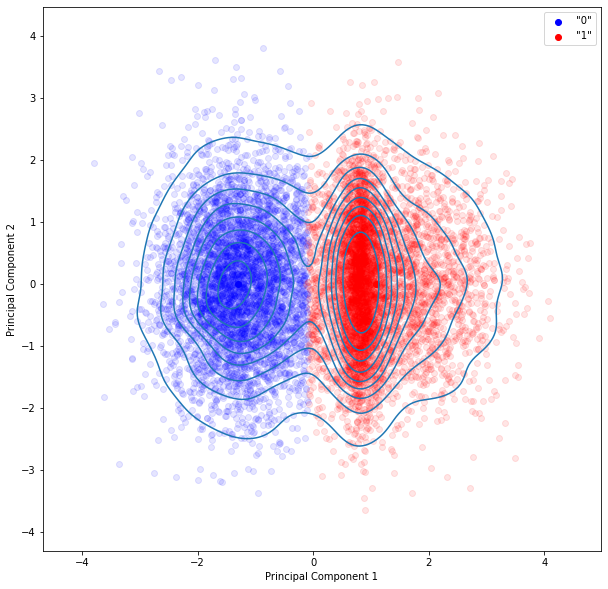

In [16]:
plt.figure(figsize = (10,10))
plt.scatter(x = principalComponents[df_fit['cluster'] == 0,0], y = principalComponents[df_fit['cluster'] == 0,1],c ='b', alpha = 1/10)
plt.scatter(x = principalComponents[df_fit['cluster'] == 1,0], y = principalComponents[df_fit['cluster'] == 1,1],c = 'r', alpha = 1/10)
plt.scatter(x = means[0,0], y = means[0,1], c = 'b', label = '"0"')
plt.scatter(x = means[1,0], y = means[1,1], c = 'r', label = '"1"')
sns.kdeplot(x = principalComponents[:,0], y = principalComponents[:,1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# 테스트

In [17]:
df_norm = df_test.copy()
df_norm[4] = scaler.fit_transform(np.array(df_norm[4]).reshape(-1, 1)).reshape(-1)

In [18]:
df_fit = df_norm.copy()
df_fit['cluster'] = model.predict(df_fit)

In [19]:
principalComponents = pca.transform(df_fit[df_train.columns[:5]])

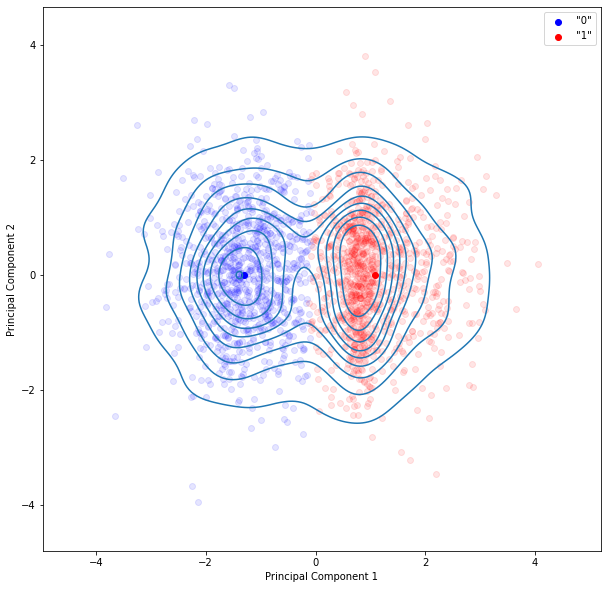

In [20]:
plt.figure(figsize = (10,10))
plt.scatter(x = principalComponents[df_fit['cluster'] == 0,0], y = principalComponents[df_fit['cluster'] == 0,1],c ='b', alpha = 1/10)
plt.scatter(x = principalComponents[df_fit['cluster'] == 1,0], y = principalComponents[df_fit['cluster'] == 1,1],c = 'r', alpha = 1/10)
plt.scatter(x = means[0,0], y = means[0,1], c = 'b', label = '"0"')
plt.scatter(x = means[1,0], y = means[1,1], c = 'r', label = '"1"')
sns.kdeplot(x = principalComponents[:,0], y = principalComponents[:,1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

In [21]:
output = df_test.copy()
output['cluster'] = df_fit['cluster']
output.to_csv("output_test.csv",index = False)